# Lesson 04: 
### Dylan Temples 
July 2, 2020

The goal of this lesson is to provide an introduction to Monte-Carlo methods, and how to run simulations in Python.

## Learning Objectives
Physics Topics:
- Monte-Carlo Methods

Programming Topics:
- Random number generation
- Sampling from distributions

Monte-Carlo methods are an extremely powerful and useful tool in physics and other areas of science. In short, Monte-Carlo methods use random variables to predict the outcome of some scenario. Generally, any simulation you run uses Monte-Carlo Methods. In this lesson, I will demonstrate how to use MC methods to run simulations and statistically analyze the output.

In [30]:
import numpy as np
import matplotlib.pyplot as plt

As an example, first let's simulate the two-step decay of $^{83m}$Kr. Imagine you have a detector that starts a timer when it detects the first 32 keV decay, and stops the time when it detects the subsequent 9 keV decay. For a single obsevation of the two-step decay, the detector tells you $t_\Delta$, the time between the decays. The value of $t_\Delta$ is a random variable, drawn from an exponential distribution characterized by the lifetime of the intermediate 9 keV state. First, let's look at this distribution.

Text(0, 0.5, 'PDF [ns$^{-1}$]')

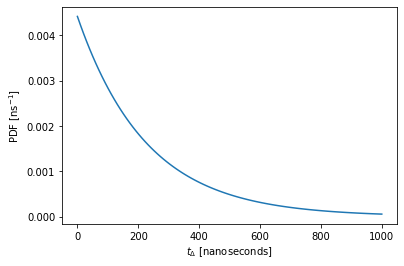

In [31]:
kr83m_9keV_halflife = 156.94 ## nanoseconds
kr83m_9keV_tau      = kr83m_9keV_halflife / np.log(2.0)   ## still nanoseconds

## Define the distribution
def exponential_pdf(t, tau):
    return (1./tau) * np.exp(-t/tau)

## Create an array of time values to sample the distribution
t_delta_vals = np.linspace(start=0.0 , stop=1000.0 , num=100)

## Determine the value of the pdf at each time
pdf_vals = exponential_pdf(t_delta_vals, kr83m_9keV_tau)

## Plot it
plt.figure()
plt.plot(t_delta_vals, pdf_vals)
plt.xlabel(r"$t_\Delta$ [nanoseconds]")
plt.ylabel(r"PDF [ns$^{-1}$]")

The above plot shows the probability of the 9 keV level decaying a specified time after the 32 keV level. So now let's run a simulation of the experiment. To do so we need to draw some number of events from this distribution. There are many ways to do this, but since the exponential distribution has a simple analytical form, the easiest will be to invert the cumulative distribution function.

The CDF is the cumulative probability at a given value of the x-axis. For example, the CDF of the distribution above at $t_\Delta = 200$ ns is the area under the curve from $t_\Delta = 0$ to $t_\Delta = 200$. The CDF of an exponential distribution is
$$ F(t, \tau) = \int_0^\infty f(t, \tau) dt = 1 - e^{-t/\tau} $$.

Text(0, 0.5, 'CDF')

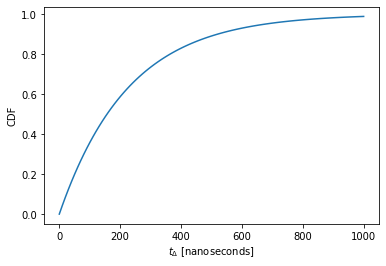

In [32]:
## define the CDF
def exponential_cdf(t, tau):
    return 1.0 - np.exp(-t/tau)

## Determine the value of the cdf at each time
cdf_vals = exponential_cdf(t_delta_vals, kr83m_9keV_tau)

## Plot it
plt.figure()
plt.plot(t_delta_vals, cdf_vals)
plt.xlabel(r"$t_\Delta$ [nanoseconds]")
plt.ylabel(r"CDF")

## Problem 1
What is the probability of observing a Kr83m decay with a time separation longer than 100 ns, but shorter than 400 ns?

In [33]:
## Put your solution to problem 1 here
P_100_400 = exponential_cdf(400., kr83m_9keV_tau) - exponential_cdf(100., kr83m_9keV_tau)
print("Probability: ",P_100_400*100,"%")

Probability:  47.20620920590124 %


The CDF has a domain that spans all prossible values of $t_\Delta$, and its range is $\in [0,1)$. Therefore the inverse CDF has a domain of $[0,1)$ and a range of all possible values of $t_\Delta$. Generating random numbers from a uniform distribution between 0 and 1 is the simplest way to get a random value in most languages. Inverting the CDF allows one to sample random variables from the specified PDF, because if you feed the inverse CDF random values uniformly distributed along its range, the random variables it outputs will be distributed like the pdf. Let's test this.

The following bit of code will run one simulated experiment from the detector we described above. Here we're simulating exactly 1000 decays observed by the detector.

Text(0, 0.5, 'Counts per bin')

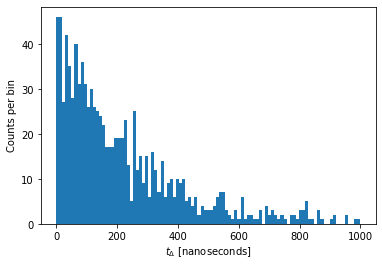

In [34]:
## define the inverse CDF
def exponential_inverse_cdf(F, tau):
    return -1. * tau * np.log(1.-F)

## generate 1000 random values uniformly distributed between 0 and 1
F_vals = np.random.rand(1000)

## calculate the inverse CDF of these values
t_vals = exponential_inverse_cdf(F_vals, kr83m_9keV_tau)

## create a histogram of these values
t_bins = np.linspace(start=0.0 , stop=1.0e3 , num=100)
plt.figure()
n_entries, bin_edges, patches = plt.hist(t_vals, bins=t_bins)
plt.xlabel(r"$t_\Delta$ [nanoseconds]")
plt.ylabel(r"Counts per bin")

This histogram looks like we expect, but how close to the PDF is it. To determine this, we'll want to plot the PDF on top of this histogram. However, since the PDF is normalized to have integral 1, we'll want to normalize the histogram in the same manner.

Text(0, 0.5, 'PDF [ns$^{-1}$]')

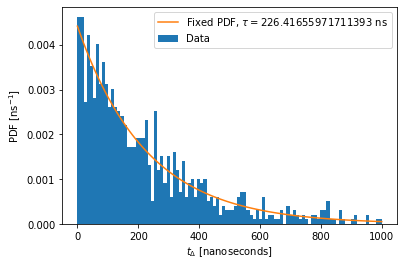

In [35]:
## create a histogram of these values
t_bins = np.linspace(start=0.0 , stop=1.0e3 , num=100)
plt.figure()
n_entries, bin_edges, patches = plt.hist(t_vals, bins=t_bins, density=1.0, label="Data")
plt.plot(t_delta_vals, pdf_vals, label=r"Fixed PDF, $\tau=$"+str(kr83m_9keV_tau)+" ns")
plt.legend(loc='upper right')
plt.xlabel(r"$t_\Delta$ [nanoseconds]")
plt.ylabel(r"PDF [ns$^{-1}$]")

So the data from our simulated experiment is distributed as we'd expect. But if we didn't know the true distribution (i.e., the true lifetime), we would have to extract it from our data. Let's do that in the same way we extracted the electron lifetime in Lesson 01.

Lifetime of 9 keV state from fit:  223.1150278607421 nanoseconds


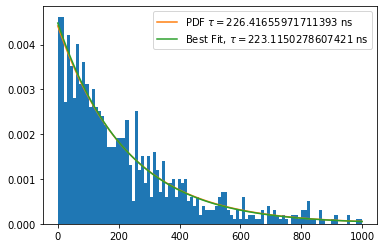

In [36]:
from scipy.optimize import curve_fit

## We extracted the bin contents and edges from the histogram above
bin_entries = n_entries   ## note this is density, not counts
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

popt, pcov = curve_fit( f = exponential_pdf, 
                        xdata = bin_centers,
                        ydata = bin_entries,
                        p0=[225])
print("Lifetime of 9 keV state from fit: ", popt[0], "nanoseconds")
fit_pdf_values = exponential_pdf(t_delta_vals, popt[0])

## Draw the normalized histogram again
plt.figure()
n_entries, bin_edges, patches = plt.hist(t_vals, bins=t_bins, density=1.0)
plt.plot(t_delta_vals, pdf_vals, label=r"PDF $\tau=$"+str(kr83m_9keV_tau)+" ns")
plt.plot(t_delta_vals, fit_pdf_values, label=r"Best Fit, $\tau=$"+str(popt[0])+" ns")
plt.legend(loc='upper right')

So we didn't get the exact lifetime out. But is the "true" value within the statistical uncertainty of our data? Let's find out.

In [37]:
tau_variance = pcov[0]
tau_err = np.sqrt(tau_variance)

lo_lim = popt[0] - tau_err[0]
hi_lim = popt[0] + tau_err[0]

print("Confidence band: ",lo_lim,"to",hi_lim,"nanoseconds")
print("Result: ",popt[0],"+/-",tau_err[0],"nanoseconds")

Confidence band:  216.5061303723222 to 229.723925349162 nanoseconds
Result:  223.1150278607421 +/- 6.608897488419898 nanoseconds


Now that we've seen that we can get a reasonable lifetime result from our simulated experiment, let's see what happens if we were to do this experiment 100 times.

In [38]:
## create a function to perform a single experiment
def RunExperiment():
    N_obs_per_experiment = 1000
    
    ## generate 1000 random values uniformly distributed between 0 and 1
    F_vals = np.random.rand(N_obs_per_experiment)
    
    ## sample from the PDF of Kr83m 9keV lifetime
    t_vals = exponential_inverse_cdf(F_vals, kr83m_9keV_tau)
    
    ## create the bins for the histogram 
    t_bins = np.linspace(start=0.0 , stop=1.0e3 , num=100)

    ## use numpy.histogram instead of matplotlib.pyplot.hist to do histogramming without making a plot
    n_entries, bin_edges = np.histogram(t_vals, bins=t_bins, density=1.0)
    
    ## calculate the bin entries and centers
    bin_entries = n_entries   ## note this is density, not counts
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    ## do the curve fit
    popt, pcov = curve_fit( f = exponential_pdf, 
                        xdata = bin_centers,
                        ydata = bin_entries,
                        p0=[225])
    
    ## return the best fit value and statistical uncertainty
    return popt[0] , np.sqrt(pcov[0])

In [39]:
## set the number of experiments to run
N_experiments_to_run = 10000

## create containers for the output of the experiments
experiment_result_vals = np.zeros(N_experiments_to_run)
experiment_result_errs = np.zeros(N_experiments_to_run)

## run the experiments and save the results
for i in np.arange(N_experiments_to_run):
    val, err = RunExperiment()
    experiment_result_vals[i] = val
    experiment_result_errs[i] = err

Now that we have the results of 100 experiments, let's look at the distribution of results.

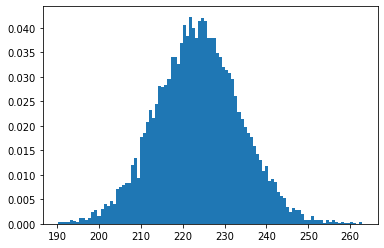

In [40]:
plt.figure()
n_t_bins = 100
n_entries_gauss, bin_edges_gauss, patches = plt.hist(experiment_result_vals, bins=n_t_bins, density=1.0)

So the results of this experiment are normally distributed around some central value. Let's fit this to a properly normalzied gaussian to see where the central value is.

Text(0, 0.5, 'Density')

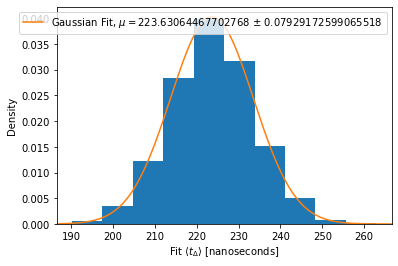

In [41]:
def gauss_pdf(x,mu,sig):
    fac = 1./ (sig*np.sqrt(2.0*np.pi))
    z = (x-mu)/sig
    return fac * np.exp(-0.5*z*z)

## calculate the bin entries and centers
bin_entries = n_entries_gauss   ## note this is density, not counts
bin_centers = 0.5 * (bin_edges_gauss[1:] + bin_edges_gauss[:-1])
    
## do the curve fit
popt, pcov = curve_fit( f = gauss_pdf, 
                    xdata = bin_centers,
                    ydata = bin_entries,
                    p0=[225,20])

## remake the figure and plot the fit
plt.figure()
ax1 = plt.gca()
n_entries_gauss, bin_edges_gauss, patches = plt.hist(experiment_result_vals, density=1.0)

xlims = ax1.get_xlim()
x_fit_vals = np.linspace(start=xlims[0], stop=xlims[1], num=1000)
y_fit_vals = gauss_pdf(x_fit_vals, popt[0], popt[1])
ax1.set_xlim(xlims)

plt.plot(x_fit_vals,y_fit_vals, label="Gaussian Fit, $\mu=$"+str(popt[0])+" $\pm$ "+str(np.sqrt(pcov[0,0])))

plt.legend(loc='upper right')
plt.xlabel(r"Fit $\langle t_\Delta \rangle$ [nanoseconds]")
plt.ylabel("Density")

The mean from the Gaussian fit should be a much closer approximation to the true value and with smaller errorbars. This is the power of repeated measurements.

## Problem 2
The above illustrated how to sample from a PDF that has an easily invertable CDF. This is not always the case. Another method that only requires a numerical PDF (as opposed to analytic, though analytic also works) is known as the accept-reject method. The concept for this method is pretty straightforward.

The procedure is as follows:
1. Determine the domain and range of your PDF
2. Generate a pair of random numbers, both from different uniform distributions. One with a value within the PDF's domain, and one with a value within the PDF's range.
3. The random number drawn from the uniform distribution spanning the PDF's domain is your "$x$" value, while the other is your "$y$" value. If $y < PDF(x)$, then the point you've generated is below your PDF and is to be accepted. If that is not the case, draw a new pair and repeat.
4. Keep track of the $x$ random variables
5. Do this some number of times to get the number of samples you want. The $x$ values will be distributed according to your PDF.

You should try to repeat the above experiments using the accpetion-rejection method instead of inverting the CDF.

What are the drawbacks to using this method? Are there any advantages this method has over inverting the CDF?

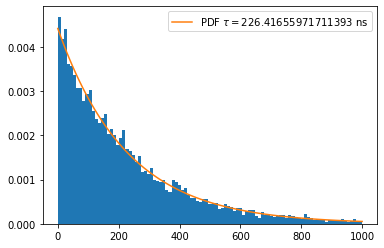

In [42]:
## Put your solution to Problem 2 here
def trial_pdf(t, tau):
    return (1./tau) * np.exp(-t/tau)

## How many samples to create
N_desired = 10000
results   = np.zeros(N_desired)

## For each desired sample
for i in np.arange(N_desired):
    found_good = False
    
    ## Keep going until I find a result below the pdf
    while(not found_good):
        r1 = np.random.rand()*1e3     #'x'
        r2 = np.random.rand()*1e-2    #'y'
        
        pdf = trial_pdf(r1,kr83m_9keV_tau)
        if (r2 <= pdf):
            results[i] = r1
            found_good = True
            
            
## Draw the normalized histogram again
plt.figure()
n_entries, bin_edges, patches = plt.hist(results, bins=t_bins, density=1.0)
plt.plot(t_delta_vals, pdf_vals, label=r"PDF $\tau=$"+str(kr83m_9keV_tau)+" ns")
plt.legend(loc='upper right')       

## Problem 3
Consider a twenty-sided die ("d20"). For a single trial, I roll the d20 twice, if either result is above 13, I win. If they're both equal to or below 13, I lose. What is the probability that I win?

This problem can be done both analytically and statistically, using the methods described above. Try it both ways, do your answers agree?

Now consider two ten-sided dice ("2d10"), where I add the resulting numbers, instead of a d20. For a single trial I roll 2d10 twice, if either result is above 13, I win. If they're both below 13, I lose. What is the probability that I win? 

For example my first 2d10 roll gives me a 3 and a 5 (sum 8), my second 2d10 roll is a 9 and a 6 (sum 15), so I win. (A single trial consists of 4 dice rolls.)

## Put your solution to Problem 3 here
For the first scenario, the probability a single d20 rolls above a 13 is 7/20. The probability I roll a 13 or lower is 13/20. Then the probability I roll two d20 and get below a 13 on both is (13/20)$\times$(13/20). That is the probability I lose. So the probability I win is one minus that.
$$ P = 1 - \left(\frac{13}{20}\right)^2 = 57.75\%$$

In [43]:
## Now we will do it statistically
N_trials = 10000
results  = np.zeros(N_trials)

def single_trial():
    r_int_1 = np.random.randint(1,high=21)   ## Note randint "high" is exclusive
    r_int_2 = np.random.randint(1,high=21)
    
    max_int = np.max([r_int_1,r_int_2])
    if (max_int > 13):
        return 1 ## I win
    else:
        return 0 ## I lose
    
for i in np.arange(N_trials):
    results[i] = single_trial()
    
N_wins = np.sum(results)
P_win  = N_wins / N_trials
print("P = ",P_win*100,"%")

P =  58.41 %


In [44]:
## Now do it with 2d10 instead of a d20
N_trials = 10000
results  = np.zeros(N_trials)

def single_trial():
    r_int_A1 = np.random.randint(1,high=11)   ## Note randint "high" is exclusive
    r_int_A2 = np.random.randint(1,high=11)
    r_int_A  = r_int_A1 + r_int_A2
    
    r_int_B1 = np.random.randint(1,high=11)   ## Note randint "high" is exclusive
    r_int_B2 = np.random.randint(1,high=11)
    r_int_B  = r_int_B1 + r_int_B2
    
    max_int = np.max([r_int_A,r_int_B])
    if (max_int > 13):
        return 1 ## I win
    else:
        return 0 ## I lose
    
for i in np.arange(N_trials):
    results[i] = single_trial()
    
N_wins = np.sum(results)
P_win  = N_wins / N_trials
print("P = ",P_win*100,"%")

P =  48.46 %
